# Classifying images of cats and Dogs using Transfer Learning

In [1]:
# Importing the Keras libraries and packages
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Using TensorFlow backend.


### Setting parameters

In [2]:
base_path = './dataset/'
batch_size = 32
img_size = 224
epochs = 5
result = ["CAT", "DOG"]

## Understanding and visualising the Test Data

We have a data set of 10000 images, Out of which 5000 images are of cat and 5000 are of dogs. 
We have distributed the data into 3 layers. 
1. Traing Data 
    3500 images of cats and dogs each. Total 7000 images
2. Validation Data
    1000 images of cats and dogs each. Total 2000 images.
3. Test Data
    500 images of cats and dogs each. Total 1000 images

In [3]:
num_cats_tr = len(os.listdir())
num_cats_tr = len(os.listdir('./dataset/training_set/cats'))
num_dogs_tr = len(os.listdir('./dataset/training_set/dogs'))

num_cats_val = len(os.listdir('./dataset/val_set/cats'))
num_dogs_val = len(os.listdir('./dataset/val_set/dogs'))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


In [4]:
print('Total training cat images:', num_cats_tr)
print('Total training dog images:', num_dogs_tr)

print('Total validation cat images:', num_cats_val)
print('Total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training cat images: 4000
Total training dog images: 4000
Total validation cat images: 1000
Total validation dog images: 1000
--
Total training images: 8000
Total validation images: 2000


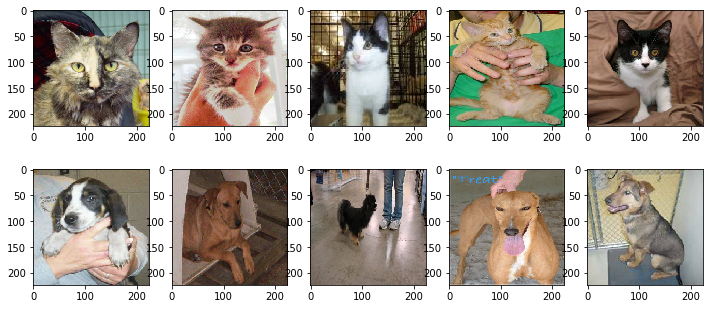

In [5]:
# let plot some of the initial example in the data
plt.figure(0, figsize=(12,20))
cpt = 0 
for ex in os.listdir(base_path + 'training_set/'):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5, cpt)
        img = load_img(base_path+"training_set/"+ex+"/" + os.listdir(base_path + "training_set/" + ex)[i], target_size=(img_size, img_size))
        plt.imshow(img)

## Data Prepration

In [6]:
train_data_gen = ImageDataGenerator(rescale=1./255)

In [7]:
train_set = train_data_gen.flow_from_directory(directory='dataset/training_set',
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode='binary')

Found 8000 images belonging to 2 classes.


In [8]:
val_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
val_set = val_data_gen.flow_from_directory(directory='dataset/val_set',
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            seed=42)

Found 2000 images belonging to 2 classes.


## Model Creation

### Model Defination 

In this section we will define our model. We are using the transfer learning here using mobilenet. We use mobilenet model and add an dense output layer with 2 output class probabilities for two classes — dogs and cats — using softmax.
We have also set mobilenet layer to non trainable hence our model wil train the output layer only and the remaining model will be fix. 

In [10]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

image_net_layer = hub.KerasLayer(CLASSIFIER_URL, input_shape=(img_size, img_size, 3))


In [11]:
image_net_layer.trainable = False

In [12]:
model = tf.keras.Sequential([ 
    image_net_layer, 
    layers.Dense(units=2, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Compiling the Model
In this setp We will complie our model and define some required parmeters of our model.
We will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [14]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                   metrics=['accuracy']
                  )

In [15]:
history = model.fit_generator(train_set,
                                  steps_per_epoch = int(np.ceil(total_train/batch_size)),
                                  epochs=epochs,
                                  validation_data= val_set,
                                  validation_steps=int(np.ceil(total_val/batch_size)))

Epoch 1/5
250/250 [==============================] - 947s 4s/step - loss: 0.0889 - accuracy: 0.9676 - val_loss: 0.0443 - val_accuracy: 0.9865
Epoch 2/5
250/250 [==============================] - 949s 4s/step - loss: 0.0421 - accuracy: 0.9858 - val_loss: 0.0352 - val_accuracy: 0.9860
Epoch 3/5
250/250 [==============================] - 973s 4s/step - loss: 0.0335 - accuracy: 0.9874 - val_loss: 0.0321 - val_accuracy: 0.9895
Epoch 4/5
250/250 [==============================] - 974s 4s/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.0321 - val_accuracy: 0.9890
Epoch 5/5
250/250 [==============================] - 1026s 4s/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0340 - val_accuracy: 0.9865


#### Visualizing results of the training
We will plot the graph to visualise how our model got trained. We plotting the training and validation data's accuracy and loss to Visualize these values

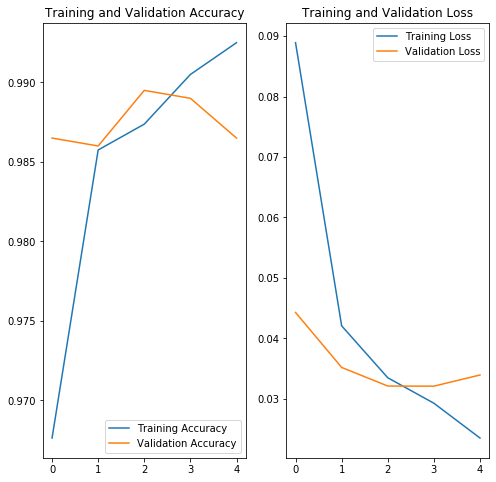

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Lets save the model parameter so that we do not have to fit it again. We can directly use this parameter to use the model in future. 

In [18]:
model.save_weights("model_weight")

### Model Summary
Using summary() method we can see the shape and different parameter of our model.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Testing the model
Now We will used the model on the dataset which it has never seen before so that we can check how our model will performe with the new and real data.
W e are using the test data set which we have kept aside to evaluate our model

In [20]:
for ex in os.listdir(base_path + 'test_set/'):
    print(ex)

cat.4058.jpg
cat.4059.jpg
cat.4060.jpg
cat.4061.jpg
cat.4062.jpg
dog.4033.jpg
dog.4034.jpg
dog.4035.jpg
dog.4036.jpg
dog.4037.jpg


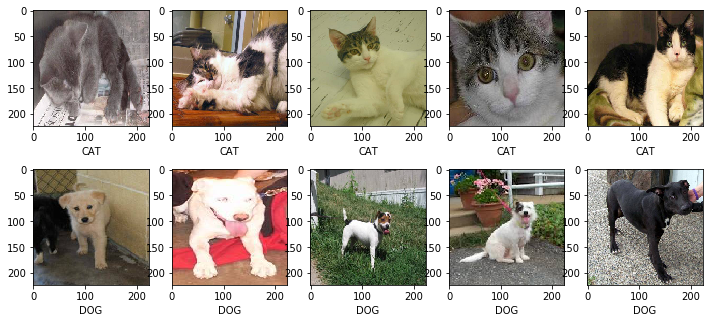

In [21]:
predictions = []
plt.figure(0, figsize=(12,20))
cpt = 0 
for ex in os.listdir(base_path + 'test_set/'):
    cpt = cpt + 1
    ax = plt.subplot(7,5, cpt)
    img = load_img((base_path+"test_set/"+ex), target_size=(img_size, img_size))
    plt.imshow(img)
    image = img_to_array(img) 
    image = np.expand_dims(image, axis=0)
    image /= 255.
    pr = model.predict(image)
    ax.set_xlabel(result[np.argmax(pr)])
    predictions.append(model.predict(image))        

In [22]:
predictions

[array([[0.9876231 , 0.01237692]], dtype=float32),
 array([[9.9994099e-01, 5.8964622e-05]], dtype=float32),
 array([[9.9999058e-01, 9.4016905e-06]], dtype=float32),
 array([[9.9998260e-01, 1.7412605e-05]], dtype=float32),
 array([[9.999027e-01, 9.725257e-05]], dtype=float32),
 array([[1.6326093e-04, 9.9983668e-01]], dtype=float32),
 array([[9.8423043e-05, 9.9990153e-01]], dtype=float32),
 array([[8.2163786e-04, 9.9917835e-01]], dtype=float32),
 array([[9.447136e-04, 9.990553e-01]], dtype=float32),
 array([[5.8410544e-04, 9.9941587e-01]], dtype=float32)]